In [4]:
from jaxtyping import Float, Array
from typing import Callable, NamedTuple, Union, Tuple, Any
from functools import partial
import chex
import optax
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax, jacfwd, vmap, grad, jit
from jax.tree_util import tree_map, tree_reduce
import flax
import flax.linen as nn
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from jax.flatten_util import ravel_pytree
from dataclasses import dataclass

from itertools import cycle

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor

from avalanche.benchmarks.classic import SplitMNIST

from rebayes.base import *
from rebayes.utils.utils import *

In [2]:
def make_avalanche_dataloaders(dataset, ntrain_per_dist, ntest_per_batch, batch_size):
    train_stream = dataset.train_stream
    test_stream = dataset.test_stream
    nexperiences = len(train_stream) # num. distinct distributions
    nbatches_per_dist = int(ntrain_per_dist / batch_size)
    ntest_per_dist = ntest_per_batch * nbatches_per_dist
    train_ndx, test_ndx = range(ntrain_per_dist), range(ntest_per_dist)

    train_sets = []
    test_sets = []
    for exp in range(nexperiences):
        ds = train_stream[exp].dataset
        train_set = torch.utils.data.Subset(ds, train_ndx)
        train_sets.append(train_set)

        ds = test_stream[exp].dataset
        test_set = torch.utils.data.Subset(ds, test_ndx)
        test_sets.append(test_set)

    train_set = torch.utils.data.ConcatDataset(train_sets)
    test_set = torch.utils.data.ConcatDataset(test_sets)

    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_set, batch_size=ntest_per_batch, shuffle=False)
    return train_dataloader, test_dataloader

In [5]:
from avalanche.benchmarks.classic import SplitMNIST

import torchvision.transforms as T
# don't need to transform to tensor for avalanche
#transform=T.Compose([T.Normalize((0.1307,), (0.3081,)), T.Lambda(torch.flatten)]) # (784)
transform=T.Compose([T.Normalize((0.1307,), (0.3081,)) ]) # (1,28,28)
n_experiences = 5
split_mnist = SplitMNIST(n_experiences=n_experiences, seed=1, return_task_id=True,
                         class_ids_from_zero_in_each_exp=True, fixed_class_order=range(10),
                         train_transform=transform, eval_transform=transform)
train_dataloader, test_dataloader = make_avalanche_dataloaders(split_mnist, 20, 500, 10)
train_iter = iter(train_dataloader)
test_iter = iter(test_dataloader)

Xtr, Ytr = avalanche_dataloader_to_numpy(train_dataloader)
Xte, Yte = avalanche_dataloader_to_numpy(test_dataloader)
Xtr_flat = flatten(Xtr)
Xte_flat = flatten(Xte)

print(Xtr.shape,  Xtr_flat.shape)
ndim_in = Xtr_flat.shape[1]
ndim_out = 1 # int

(100, 1, 28, 28) (100, 784)


In [6]:
def plot_batch(Xb, Yb):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        #sample_idx = torch.randint(len(training_data), size=(1,)).item()
        sample_idx = i-1
        img = Xb[sample_idx]
        label = Yb[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

step i  0
train size:  torch.Size([10, 1, 28, 28]) torch.Size([10]) torch.Size([10])
test size: torch.Size([500, 1, 28, 28]) torch.Size([500]) torch.Size([500])


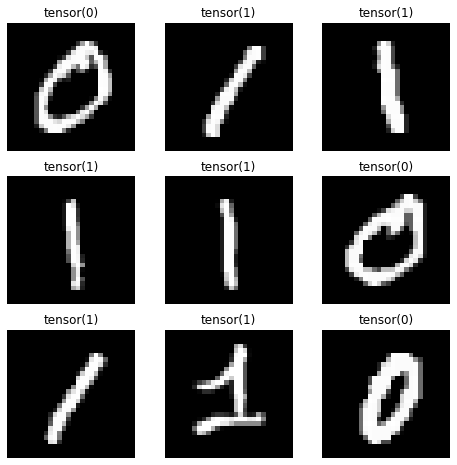

tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0])
step i  1
train size:  torch.Size([10, 1, 28, 28]) torch.Size([10]) torch.Size([10])
test size: torch.Size([500, 1, 28, 28]) torch.Size([500]) torch.Size([500])


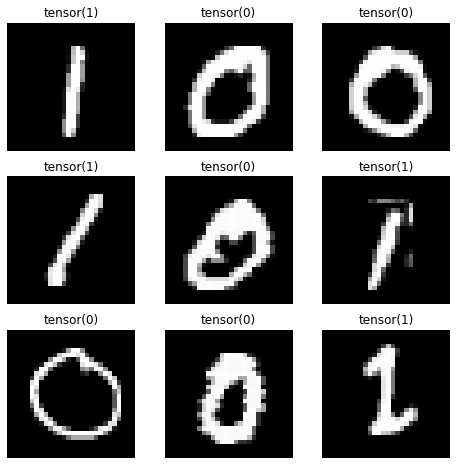

tensor([1, 0, 0, 1, 0, 1, 0, 0, 1, 1])
step i  2
train size:  torch.Size([10, 1, 28, 28]) torch.Size([10]) torch.Size([10])
test size: torch.Size([500, 1, 28, 28]) torch.Size([500]) torch.Size([500])


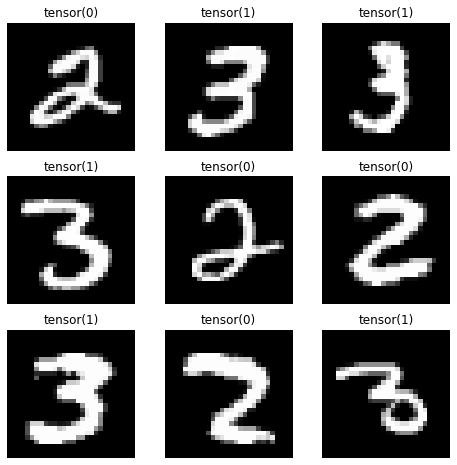

tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 1])
step i  3
train size:  torch.Size([10, 1, 28, 28]) torch.Size([10]) torch.Size([10])
test size: torch.Size([500, 1, 28, 28]) torch.Size([500]) torch.Size([500])


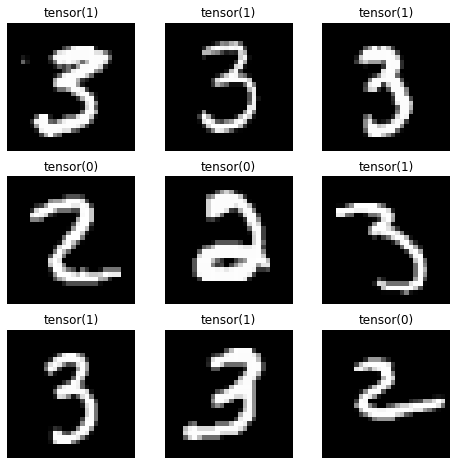

tensor([1, 1, 1, 0, 0, 1, 1, 1, 0, 1])
step i  4
train size:  torch.Size([10, 1, 28, 28]) torch.Size([10]) torch.Size([10])
test size: torch.Size([500, 1, 28, 28]) torch.Size([500]) torch.Size([500])


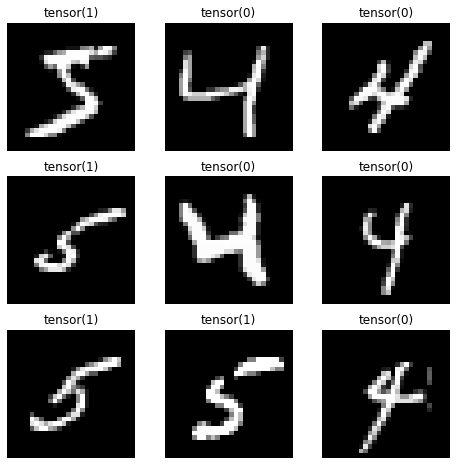

tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0])
step i  5
train size:  torch.Size([10, 1, 28, 28]) torch.Size([10]) torch.Size([10])
test size: torch.Size([500, 1, 28, 28]) torch.Size([500]) torch.Size([500])


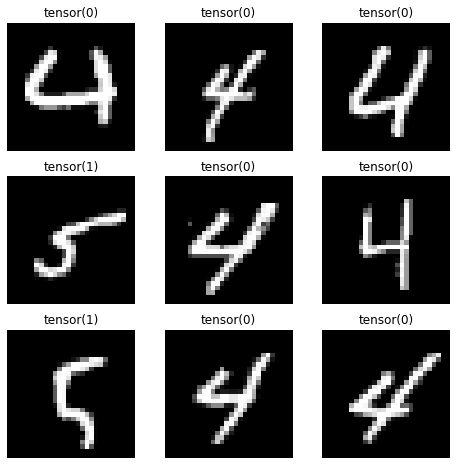

tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])


In [7]:

nbatches = len(train_dataloader)
assert len(test_dataloader)==nbatches
for i in range(min(6, nbatches)):
    print('step i ', i)
    (Xb, Yb, Tb) = next(train_iter)
    print('train size: ', Xb.shape, Yb.shape, Tb.shape)
    (Xte, Yte, Tte) = next(test_iter)
    print('test size:', Xte.shape, Yte.shape, Tte.shape)
    #print(Yb, Tb)
    plot_batch(Xb, Yb)
    print(Yb)

In [8]:
def callback_dl(bel,  b, Xtr, Ytr, Xte, Yte, **kwargs):
    jax.debug.print("callback on batch {b}", b=b)
    jax.debug.print("Xtr shape {x1}, Ytr shape {y1}", x1=Xtr.shape, y1=Ytr.shape)
    jax.debug.print("Xte shape {x1}, Yte shape {y1}", x1=Xte.shape, y1=Yte.shape)
    #jax.debug.print("pre dummy {a}, post dummy {b}", a=bel_pre_update.dummy, b=bel.dummy)
    return b

In [9]:
class RebayesSum(Rebayes):
    """The belief state is the sum of all the input X_t values."""
    def __init__(
        self,
        params: RebayesParams,
        ndim_in: int, 
        ndim_out: int
    ):
        self.params = params
        self.ndim_in = ndim_in
        self.ndim_out = ndim_out

    def init_bel(self) -> Belief:
        bel = Belief(dummy = jnp.zeros((self.ndim_in,)))
        return bel
    
    def update_state(
        self,
        bel: Belief,
        X: Float[Array, "input_dim"],
        Y: Float[Array, "obs_dim"]
    ) -> Belief:
        return Belief(dummy = bel.dummy + X)

In [16]:

estimator = RebayesSum(make_rebayes_params(), ndim_in, ndim_out)
bel, outputs = estimator.scan_dataloader(train_dataloader, test_dataloader, callback_dl, verbose=True,
                                        has_task_id=True, flatten_data=True)
Xsum = jnp.sum(Xtr_flat, axis=0)
assert(jnp.allclose(Xsum, bel.dummy, atol=1e-2))

batch  0
callback on batch 0
Xtr shape (10, 784), Ytr shape (10,)
Xte shape (500, 784), Yte shape (500,)
batch  1
callback on batch 1
Xtr shape (10, 784), Ytr shape (10,)
Xte shape (500, 784), Yte shape (500,)
batch  2
callback on batch 2
Xtr shape (10, 784), Ytr shape (10,)
Xte shape (500, 784), Yte shape (500,)
batch  3
callback on batch 3
Xtr shape (10, 784), Ytr shape (10,)
Xte shape (500, 784), Yte shape (500,)
batch  4
callback on batch 4
Xtr shape (10, 784), Ytr shape (10,)
Xte shape (500, 784), Yte shape (500,)
batch  5
callback on batch 5
Xtr shape (10, 784), Ytr shape (10,)
Xte shape (500, 784), Yte shape (500,)
batch  6
callback on batch 6
Xtr shape (10, 784), Ytr shape (10,)
Xte shape (500, 784), Yte shape (500,)
batch  7
callback on batch 7
Xtr shape (10, 784), Ytr shape (10,)
Xte shape (500, 784), Yte shape (500,)
batch  8
callback on batch 8
Xtr shape (10, 784), Ytr shape (10,)
Xte shape (500, 784), Yte shape (500,)
batch  9
callback on batch 9
Xtr shape (10, 784), Ytr s